In [1]:
%load_ext autoreload 
%autoreload 2

%aimport -pandas
%aimport -scipy.stats
%aimport -numpy
%aimport -matplotlib.pyplot

import default_calcs as default
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas
import collateral_waterfall as cw
import prepayment_calcs as pc
import xlwings as xw

pd.options.display.float_format = '{:,.2f}'.format

In [2]:
initial_balance = 100e6    # 100 million
net_coupon      = 0.10     # 10%
gross_coupon    = 0.1065   # 10.65%
maturity        = 360      # 30 years => monthly
servicing       = 0.0   # servicing = 25bps

bonds = [
    {'Bond': 'A',
    'Balance': 30e6,
    'Coupon': 0.07},

    {'Bond': 'B',
    'Balance': 40e6,
    'Coupon': 0.09},
    
    {'Bond': 'C',
    'Balance': 30e6,
    'Coupon': 0.10}
]

bonds_with_zbond = [
    {'Bond': 'A',
    'Balance': 30e6,
    'Coupon': 0.07},

    {'Bond': 'B',
    'Balance': 40e6,
    'Coupon': 0.09},
    
    {'Bond': 'Z',
    'Balance': 30e6,
    'Coupon': 0.10,
    'Type': 'accrual'}
]

In [3]:
psa_100 = cw.create_waterfall(original_balance=initial_balance,
                             pass_thru_cpn=net_coupon,
                             wac=gross_coupon,
                             wam=maturity,
                             psa_speed=1,
                             servicing=servicing)
psa_175 = cw.create_waterfall(original_balance=initial_balance,
                             pass_thru_cpn=net_coupon,
                             wac=gross_coupon,
                             wam=maturity,
                             psa_speed=1.75,
                             servicing=servicing)
psa_400 = cw.create_waterfall(original_balance=initial_balance,
                             pass_thru_cpn=net_coupon,
                             wac=gross_coupon,
                             wam=maturity,
                             psa_speed=4,
                             servicing=servicing)

In [ ]:
print('PSA\tAverage Life')
print('100%:\t{0:.2f}'.format(weighted_average_life(psa_100)/12))
print('175%:\t{0:.2f}'.format(weighted_average_life(psa_175)/12))
print('400%:\t{0:.2f}'.format(weighted_average_life(psa_400)/12))


In [ ]:
%matplotlib
frames = [psa_100,psa_175,psa_400]

fig, axes = plt.subplots(3,2)
for i in range(3):
    for j in range(2):
        if j == 0:
            axes[i,j].fill_between(frames[i].index-1,
                                  frames[i].beginning_balance)
        else:
            axes[i,j].stackplot(frames[i].index-1, 
                          frames[i].scheduled_principal,
                          frames[i].prepayments,
                          frames[i].net_interest,
                          frames[i].servicing)
            
plt.tight_layout(True)
plt.show()

In [ ]:
%%time

%matplotlib inline
import xlwings as xw
wb = xw.Book('G:/Programming/Python/zeusRMBS/workbooks/Chapter 6 - CMOs.xlsx')
ChartData = wb.sheets('ChartData')

import CMO_waterfall as cmo

struct = cmo.CMO(original_balance=initial_balance,
                             pass_thru_cpn=net_coupon,
                             wac=gross_coupon,
                             wam=maturity,
                             psa_speed=1.75,
                             servicing=servicing,
                             bonds=bonds)

print(((struct.waterfall.index.values * struct.waterfall['Cashflow_A']).sum() / 
    struct.waterfall['Cashflow_A'].sum()) / 12)

print(((struct.waterfall.index.values * struct.waterfall['Cashflow_B']).sum() / 
    struct.waterfall['Cashflow_B'].sum()) / 12)

print(((struct.waterfall.index.values * struct.waterfall['Cashflow_C']).sum() / 
    struct.waterfall['Cashflow_C'].sum()) / 12)


print(((struct.waterfall.index.values * struct.waterfall['Principal_A']).sum() / 
    struct.waterfall['Principal_A'].sum()) / 12)

print(((struct.waterfall.index.values * struct.waterfall['Principal_B']).sum() / 
    struct.waterfall['Principal_B'].sum()) / 12)

print(((struct.waterfall.index.values * struct.waterfall['Principal_C']).sum() / 
    struct.waterfall['Principal_C'].sum()) / 12)

ChartData.range('A1').expand().value = ""
ChartData.range('A1').value = struct.waterfall[['Interest_Paid_A',
                                           'Principal_A',
                                           'Interest_Paid_B',
                                           'Principal_B',
                                           'Interest_Paid_C',
                                           'Principal_C',
                                           'remaining_principal',
                                           'remaining_interest']]

wb.sheets('Waterfall').range('A1').value = struct.waterfall

fig, ax = plt.subplots(1,1)
ax = plt.stackplot(struct.waterfall.index.values.tolist(),
                struct.waterfall.Principal_A.values.tolist(),
                struct.waterfall.Principal_B.values.tolist(),
                struct.waterfall.Principal_C.values.tolist(),
                struct.waterfall.Interest_Paid_A.values.tolist(),
                struct.waterfall.Interest_Paid_B.values.tolist(),
                struct.waterfall.Interest_Paid_C.values.tolist())
handles = []
labels = ['Principal A','Principal B','Principal C','Interest A','Interest B','Interest C']
for axis in ax:
    handles.append(axis)
    axis.set_clip_on(True)
    axis.axes.grid(True, alpha=0.2)
    
fig.frameon=False
#fig.tightbbox=True
fig.tight_layout()
fig.legend(handles, labels, loc=(.68,.50), fancybox=True)
plt.axis(xmin=0, xmax=360)

figure = wb.sheets('figure')
figure.pictures.add(fig, name='CMO Watefall', update=True)



In [ ]:
#%matplotlib inline
import CMO_waterfall as cmo

struct = cmo.CMO(original_balance=initial_balance,
                             pass_thru_cpn=net_coupon,
                             wac=gross_coupon,
                             wam=maturity,
                             psa_speed=1.75,
                             servicing=servicing,
                             bonds=bonds_with_zbond)

In [ ]:
import xlwings as xw
wb = xw.Book('G:/Programming/Python/zeusRMBS/workbooks/Chapter 6 - CMOs _ accrual bond.xlsx')
ChartData = wb.sheets('ChartData')


print(((struct.waterfall.index.values * struct.waterfall['Principal_A']).sum() / 
    struct.waterfall['Principal_A'].sum()) / 12)

print(((struct.waterfall.index.values * struct.waterfall['Principal_B']).sum() / 
    struct.waterfall['Principal_B'].sum()) / 12)

print(((struct.waterfall.index.values * struct.waterfall['Principal_Z']).sum() / 
    struct.waterfall['Principal_Z'].sum()) / 12)

ChartData.range('A1').expand().value = ""
ChartData.range('A1').value = struct.waterfall[['Interest_Paid_A',
                                           'Principal_A',
                                           'Interest_Paid_B',
                                           'Principal_B',
                                           'Interest_Paid_Z',
                                           'Principal_Z',
                                           'remaining_principal',
                                           'remaining_interest']]

wb.sheets('Waterfall').range('A1').value = struct.waterfall

fig, ax = plt.subplots(1,1)



ax = plt.stackplot(struct.waterfall.index.values.tolist(),
                struct.waterfall.Principal_A.values.tolist(),
                struct.waterfall.Principal_B.values.tolist(),
                (struct.waterfall.Principal_Z.values +
                (struct.waterfall.Interest_Due_Z.values - 
                 struct.waterfall.Interest_Paid_Z.values)).tolist(),
                struct.waterfall.Interest_Paid_A.values.tolist(),
                struct.waterfall.Interest_Paid_B.values.tolist(),
                struct.waterfall.Interest_Paid_Z.values.tolist())
handles = []
labels = ['Principal A','Principal B','Principal Z','Interest A','Interest B','Interest Z']
for axis in ax:
    handles.append(axis)
    axis.set_clip_on(True)
    axis.axes.grid(True, alpha=0.2)
    
fig.frameon=False
#fig.tightbbox=True
fig.tight_layout()
fig.legend(handles, labels, loc=(.68,.50), fancybox=True)
plt.axis(xmin=0, xmax=360)

figure = wb.sheets('figure')
figure.pictures.add(fig, name='CMO Watefall', update=True)

In [ ]:
import CMO_waterfall as cmo

struct = cmo.CMO(original_balance=initial_balance,
                             pass_thru_cpn=net_coupon,
                             wac=gross_coupon,
                             wam=maturity,
                             psa_speed=1.75,
                             servicing=servicing,
                             bonds=bonds)

pro_rata_B = {
    'source_bond': 'B',
    'child_bonds': {'B1':0.75,'B2':0.25}
}

pro_ratas = [pro_rata_B]
struct.create_pro_rata_bonds(pro_ratas)

fig, ax = plt.subplots(1,1)



ax = plt.stackplot(struct.waterfall.index.values.tolist(),
                struct.waterfall.Principal_A.values.tolist(),
                struct.waterfall.Principal_B2.values.tolist(),
                struct.waterfall.Principal_B1.values.tolist(),
                struct.waterfall.Principal_C.values.tolist())
#                struct.waterfall.Interest_Paid_A.values.tolist(),
#                struct.waterfall.Interest_Paid_B1.values.tolist(),
#                struct.waterfall.Interest_Paid_B2.values.tolist(),
#                struct.waterfall.Interest_Paid_C.values.tolist())
handles = []
labels = ['Principal A',
          'Principal B2', 
          'Principal B1', 
          'Principal C']
#          'Interest A', 
#          'Interest B1',
#          'Interest B2',
#          'Interest C']
for axis in ax:
    handles.append(axis)
    axis.set_clip_on(True)
    axis.axes.grid(True, alpha=0.2)
    
fig.frameon=False
#fig.tightbbox=True
fig.tight_layout()
fig.legend(handles, labels, loc=(.68,.50), fancybox=True)
plt.axis(xmin=0, xmax=360)

plt.show()


In [ ]:
bonds

In [ ]:
round(.09 + (.75 / .25 * (.09 - .08)),5)

In [3]:
floater_size = .75
inverse_size = .25
available_coupon = 0.09
floater_margin = 0.01

inverse_zero = available_coupon - margin

leverage = floater_size / inverse_size
inverse_zero_diff = available_coupon - inverse_zero 

def floater_cap(floater_size = .75,
                inverse_size = .25,
                available_coupon = 0.09,
                floater_margin = 0.01):
    
    inverse_zero = available_coupon - margin

    leverage = floater_size / inverse_size
    inverse_zero_diff = available_coupon - inverse_zero 

    
    return round(
        available_coupon + (leverage * inverse_zero_diff),
        5)

def inverse_max(floater_size = .75,
                inverse_size = .25,
                available_coupon = 0.09,
                floater_margin = 0.01):

    inverse_zero = available_coupon - margin

    leverage = floater_size / inverse_size
    inverse_zero_diff = available_coupon - inverse_zero

    return round((available_coupon +
                   leverage * (available_coupon - margin)),
                        5)

def floater_rates(floater_size = .75,
                 inverse_size = .25,
                available_coupon=0.09,
                margin=0.01,
                rate=0.):
    floater_rate = min(rate + margin, available_coupon + (1 / leverage * available_coupon))
    
    inverse_rate = max((available_coupon + leverage * (available_coupon - floater_rate)),0)
    
    return floater_rate, inverse_rate


NameError: name 'margin' is not defined

In [ ]:
rates = pd.Series([3,6,9,12,15])/100
ex6_5 = pd.DataFrame(index=rates,columns=['Floater','Inverse'])
ex6_5.index.name='LIBOR'

In [ ]:
ex6_5[['Floater','Inverse']] = [floater_rates(rate=rate) for rate in ex6_5.index.values]
#ex6_5['Inverse'] = [inverse_rate(rate=rate) for rate in ex6_5.index.values]

In [ ]:
ex6_5.plot()

In [ ]:
import utils

In [ ]:
floater_rates(rate=0)

In [ ]:
psa_100 = cw.create_waterfall(psa_speed=1)
psa_300 = cw.create_waterfall(psa_speed=3)

In [8]:
pd.options.display.float_format = '{:,.2f}'.format

def calc_PAC_and_support(collateral_waterfall, 
                         lower_band=1, 
                         upper_band=3):
    
    lower_df = cw.create_waterfall(original_balance=initial_balance,
                                     pass_thru_cpn=net_coupon,
                                     wac=gross_coupon,
                                     wam=maturity,
                                     psa_speed=lower_band,
                                     servicing=servicing)
    upper_df = cw.create_waterfall(original_balance=initial_balance,
                                     pass_thru_cpn=net_coupon,
                                     wac=gross_coupon,
                                     wam=maturity,
                                     psa_speed=upper_band,
                                     servicing=servicing)
    
    pac_df = pd.DataFrame(data=[lower_df.total_principal.values, 
                           upper_df.total_principal.values],
                    ).T
    pac_df.columns=['PAC_lower_' + str(int(lower_band * 100)),'PAC_upper_' + str(int(upper_band * 100))]
    pac_df.index=collateral_waterfall.index
    pac_df['PAC_principal_due'] = pac_df.apply(
        min,axis=1)
    
    pac_df['available_principal'] = collateral_waterfall.total_principal

    pac_initial_balance = pac_df.PAC_principal_due.sum()
    pac_new_balance = pac_initial_balance
    support_initial_balance = collateral_waterfall.loc[1,'beginning_balance'] - pac_initial_balance
    support_new_balance = support_initial_balance
    
    pac_df.loc[1,'PAC_balance'] = pac_initial_balance
    pac_df.loc[1,'Support_balance'] = support_initial_balance
    
    pac_df['PAC_unpaid_principal'] = 0
    pac_df['PAC_principal_paid'] = 0
    pac_df['Support_principal_paid'] = 0
    
    for period, values in pac_df.loc[1:].iterrows():

        pac_accrued_unpaid = 0
        
        if period > 1:
            pac_accrued_unpaid = pac_df.loc[period-1,'PAC_unpaid_principal']
        
            pac_new_balance = pac_df.loc[period-1,'PAC_balance'] - pac_df.loc[period-1,'PAC_principal_paid']
            support_new_balance = pac_df.loc[period-1,'Support_balance'] - pac_df.loc[period-1,'Support_principal_paid']

            pac_df.loc[period,'PAC_balance'] = pac_new_balance
            pac_df.loc[period,'Support_balance'] = support_new_balance
        
        
        pac_principal_due = values['PAC_principal_due'] + pac_accrued_unpaid
        principal_available = values['available_principal']

        pac_principal_paid = min(pac_principal_due, principal_available)
        support_principal_paid = max(min(support_new_balance, principal_available - pac_principal_paid), 0)
        
        pac_principal_paid += (principal_available - pac_principal_paid - support_principal_paid)
                
        unpaid_principal = max(pac_df.loc[:period,'PAC_principal_due'].sum() - 
                               (pac_df.loc[:period,'PAC_principal_paid'].sum() + pac_principal_paid),0)

        pac_df.loc[period, ['PAC_principal_paid',
                            'PAC_unpaid_principal',
                            'Support_principal_paid']] = [pac_principal_paid, 
                                                          unpaid_principal,
                                                          support_principal_paid]
        
        


    
    #collateral_waterfall = collateral_waterfall.merge(PAC_df, left_index=True, right_index=True)
    #collateral_waterfall['Support'] = (collateral_waterfall.total_principal - 
    #                                    collateral_waterfall['PAC_principal_due']).apply(lambda x: max(x,0))

    return pac_df
    
def return_PAC_Support_avg_life(waterfall):
    pac = (waterfall.index.values * waterfall.PAC_principal_paid).sum() / (waterfall.PAC_principal_paid.sum())/12
    support = (waterfall.index.values * waterfall.Support_principal_paid).sum() / (waterfall.Support_principal_paid.sum())/12
    
    return [pac, support]
    

In [7]:
%%time

import collateral_waterfall as cw

# psa=1 for 5 years then psa=3 for remainder

speed = [1] * 60 + [3] * 300


collateral = cw.create_waterfall(original_balance=initial_balance,
                                     pass_thru_cpn=net_coupon,
                                     wac=gross_coupon,
                                     wam=maturity,
                                     psa_speed=speed,
                                     servicing=servicing)
a=collateral.merge(calc_PAC_and_support(collateral,1,3), left_index=True, right_index=True)

wb = xw.Book()
wb.sheets(1).range('A1').value = a

Wall time: 2.21 s


In [ ]:
return_PAC_Support_avg_life(a)

In [ ]:
import xlwings as xw
wb = xw.Book()
wb.sheets(1).range('A1').value = a


In [5]:
speeds = [0.75, 1, 1.75, 3, 4]
ex_6_6f = pd.DataFrame(index=speeds, columns=['PAC','Support'])
ex_6_6f.index.name='PSA'

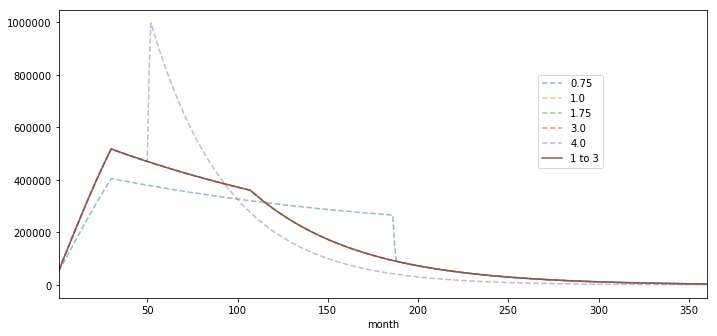

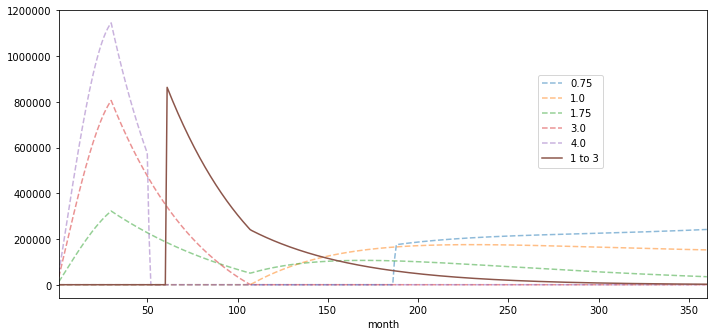

In [10]:
waterfalls = {}

w, h = 3,2

rect = 0,0,w,h

fig1 = plt.figure(figsize=(w,h))
ax1 = fig1.add_axes(rect)

fig2 = plt.figure(figsize=(w,h))
ax2 = fig2.add_axes(rect)

for speed in ex_6_6f.index.values:
    waterfalls[speed] = calc_PAC_and_support(cw.create_waterfall(
                             original_balance=initial_balance,
                             pass_thru_cpn=net_coupon,
                             wac=gross_coupon,
                             wam=maturity,
                             psa_speed=speed,
                             servicing=servicing),
                             1,
                             3)
    
    waterfalls[speed]['PAC_principal_paid'].plot(style='--', alpha=0.5, ax=ax1, label=speed)
    waterfalls[speed]['Support_principal_paid'].plot(style='--', alpha=0.5, ax=ax2, label=speed)
    
    
    ex_6_6f.loc[speed,['PAC','Support']] = return_PAC_Support_avg_life(waterfalls[speed])
    
speed = [1] * 60 + [3] * 300


collateral = cw.create_waterfall(original_balance=initial_balance,
                                     pass_thru_cpn=net_coupon,
                                     wac=gross_coupon,
                                     wam=maturity,
                                     psa_speed=speed,
                                     servicing=servicing)
waterfalls['1 to 3'] = calc_PAC_and_support(collateral,1,3)
waterfalls['1 to 3']['PAC_principal_paid'].plot(style='-', alpha=1, ax=ax1, label='1 to 3')
waterfalls['1 to 3']['Support_principal_paid'].plot(style='-', alpha=1, ax=ax2, label='1 to 3')


loc = (.75,.5)    
    
handles1, labels1 = ax1.get_legend_handles_labels()
fig1.legend(handles1, labels1, loc=loc)
handles2, labels2 = ax2.get_legend_handles_labels()
fig2.legend(handles2, labels2, loc=loc)

plt.show()

In [ ]:
waterfalls[.75]['PAC_principal_paid'].plot()
plt.show()

In [7]:
for speed in ex_6_6f.index.values:
    ex_6_6f.loc[speed,['PAC','Support']] = return_PAC_Support_avg_life(
        calc_PAC_and_support(cw.create_waterfall(
                             original_balance=initial_balance,
                             pass_thru_cpn=net_coupon,
                             wac=gross_coupon,
                             wam=maturity,
                             psa_speed=speed,
                             servicing=servicing),
                             1,
                             3))

ex_6_6f

NameError: name 'return_PAC_Support_avg_life' is not defined

In [ ]:
fig3 = plt.figure()
rect = 0,0,10,10
ax3 = fig3.add_axes(rect)

In [ ]:
ax3